In [1]:
def findexact(str, substr, index=0):
  offset = str.find(substr)
  ln = len(substr)
  if not index:
    return offset
  return offset + ln + findexact(str[offset+ln :], substr, index-1)

def multifind(str, substrs):
  ret = len(str)
  for substr in substrs:
    index = findexact(str, substr)
    if index > -1 and index < ret:
      ret = index
  if ret == len(str):
    ret = -1
  return ret

In [2]:
!pip install gdown --quiet
!pip install docx2txt --quiet

  Preparing metadata (setup.py) ... done


In [61]:
import gdown
import docx2txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

In [4]:
!gdown 12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb

Downloading...
From: https://drive.google.com/uc?id=12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb
To: /content/CCXXXI.docx
100% 373k/373k [00:00<00:00, 75.6MB/s]


In [70]:
txt = docx2txt.process("CCXXXI.docx")

In [71]:
months = ["vendémiaire", "brumaire", "frimaire", "nivôse", "pluviôse", "ventôse",
          "germinal", "floréal", "prairial", "messidor", "thermidor", "fructidor"]
for month in months:
  txt = txt.replace(month.upper(), "")

labels = ["monologue", "story", "fanfic", "chguestk", "cliff", "letter", "lyrics"]

df = pd.DataFrame(columns=["name", "day", "month", "greg_day", "greg_month", "label", "text"])

while(multifind(txt, labels) != -1):
  start = multifind(txt, labels)
  label = txt[start : txt.find(" ", start)]
  txt = txt[start + len(label) :]
  day = pd.Series({
      "name" : txt[findexact(txt, " ", 3) + 1 : findexact(txt, "\n")],
      "day" : int(txt[findexact(txt, " ", 1) + 1 : findexact(txt, " ", 2)]),
      "month" : txt[findexact(txt, " ", 2) + 1 : findexact(txt, ".", 1)],
      "greg_day" : int(txt[findexact(txt, "(") + 1 : findexact(txt, ".")]),
      "greg_month" : int(txt[findexact(txt, ".") + 1 : findexact(txt, ")")]),
      "label" : label,
      "text" : txt[findexact(txt, "\n", 1) + 1 : multifind(txt, labels)],
  })
  df = pd.concat([df, day.to_frame().T], ignore_index=True)

In [72]:
df["text"] = df["text"].map(lambda x: " ".join(x.split()))
df["sentences"] = df["text"].map(lambda x: len(x.replace("?", ".").replace("!", ".").split(". ")))
df["words"] = df["text"].map(lambda x: len(x.replace("-", "").split()))
df["symbols"] = df["text"].map(lambda x: len(x.replace(" ", "")))
df["capitals"] = df["text"].map(lambda x: len(list(filter(lambda c: c.isupper(), x))))
df["dashes"] = df["text"].map(lambda x: len(list(filter(lambda w: w == "-", x.split()))))
df["questions"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "?", x))))
df["exclamations"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "!", x))))

In [8]:
df

,name,day,month,greg_day,greg_month,label,text,sentences,words,symbols,capitals,dashes,questions,exclamations
0,raisin,1,vendémiaire,23,9,monologue,люди не изменились. ароматная жидкость мягко к...,17,238,1339,0,4,2,0
1,safran,2,vendémiaire,24,9,story,Сафран горд своим прозвищем. нет большого смыс...,21,333,1940,5,3,1,1
2,châtaigne,3,vendémiaire,25,9,story,Кристине исполняется четыре года. белокурая ма...,30,514,2824,10,13,5,2
3,colchique,4,vendémiaire,26,9,story,с тихим звонком открываются двери лифта. мягки...,37,339,1907,30,12,6,2
4,cheval,5,vendémiaire,27,9,story,Келлер Долль привычным движением запрыгивает в...,22,374,2252,10,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,granit,11,nivôse,1,1,monologue,гранит - визитная карточка Земли. ни на одном ...,10,269,1667,2,9,0,0
101,argile,12,nivôse,2,1,chguestk,"не все могут блистать. не все хотят. и, к счас...",20,245,1468,2,4,2,0
102,ardoise,13,nivôse,3,1,story,"по всем каналам связи - на телевидении, по рад...",14,259,1657,0,5,1,0
103,grès,14,nivôse,4,1,fanfic,"забудьте всё, что помнили о ней, как забываю э...",22,314,1657,3,6,2,0


In [86]:
df[df["label"] == "monologue"].sort_values(by=["exclamations", "questions"], ascending=False).head(10)

,name,day,month,greg_day,greg_month,label,text,sentences,words,symbols,capitals,dashes,questions,exclamations
59,rouleau,30,brumaire,21,11,monologue,что необходимо коллективу для достижения успех...,17,297,1795,0,8,2,2
31,céleri,2,brumaire,24,10,monologue,"многим из вас мы можем быть противны, и я пони...",18,328,1914,0,11,1,1
77,lierre,18,frimaire,9,12,monologue,"прохожих на улице, незнакомцев в соцсетях, люд...",18,350,2046,0,5,1,1
85,pignon,26,frimaire,17,12,monologue,"""прости, мы старались выбрать такое время, ког...",19,398,2221,0,9,5,0
22,navet,23,vendémiaire,15,10,monologue,"мусор или искусство? где проходит граница, раз...",18,318,1921,0,6,4,0
14,âne,15,vendémiaire,7,10,monologue,"кожа скота - очень полезная вещь, никогда не п...",14,263,1526,1,4,3,0
97,fumier,8,nivôse,29,12,monologue,"считают, что детей нужно просто пичкать книгам...",19,336,1795,0,5,3,0
0,raisin,1,vendémiaire,23,9,monologue,люди не изменились. ароматная жидкость мягко к...,17,238,1339,0,4,2,0
30,pomme,1,brumaire,23,10,monologue,"город весь, от земли до неба, завешан рекламой...",14,298,1647,0,5,2,0
34,oie,5,brumaire,27,10,monologue,прогресс человечества в основном объясняется л...,17,332,1930,0,2,2,0


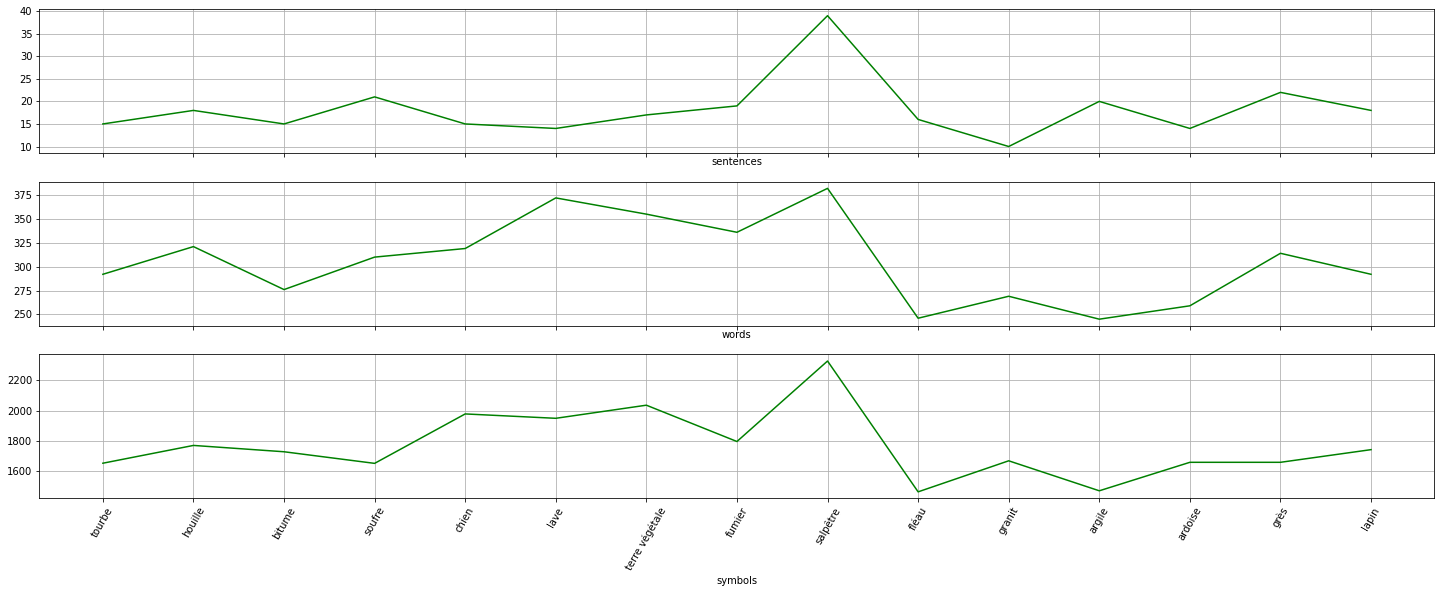

In [9]:
batch = df[df["month"] == months[3]]

plots = ["sentences", "words", "symbols"]
# plots = ["capitals", "dashes", "questions", "exclamations"]
fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(25,3 * len(plots)))
for i in range(len(plots)):
  axs[i].plot(batch["name"], batch[plots[i]], 'g')
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.xticks(rotation=60)
plt.show()

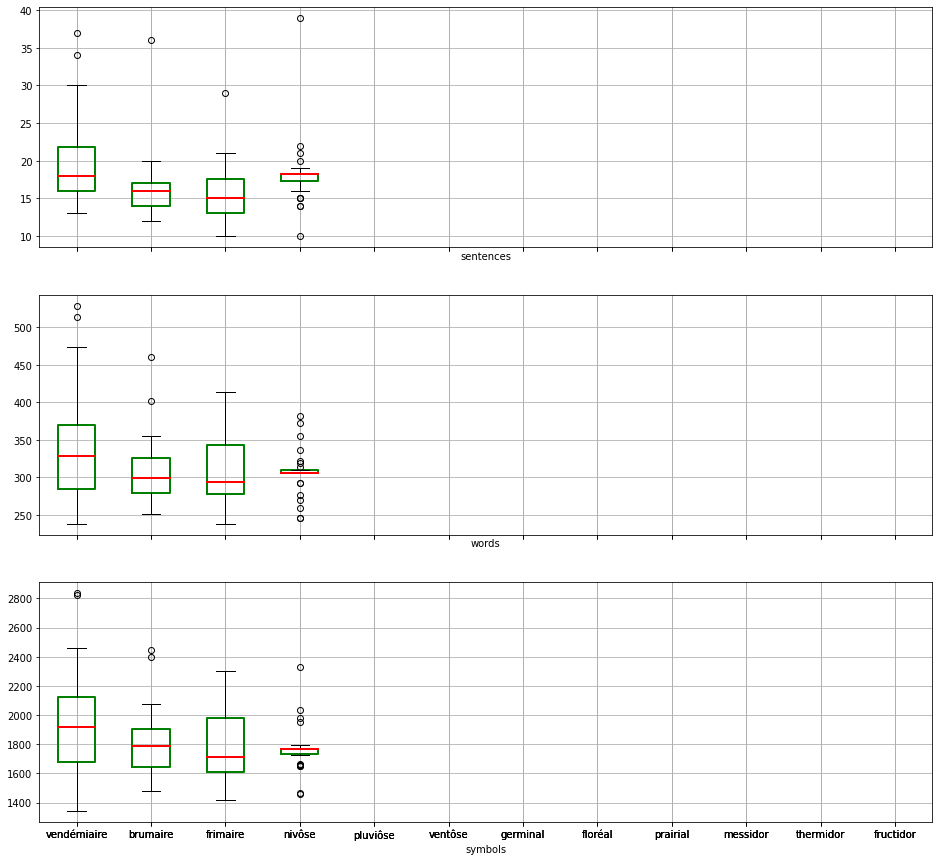

In [10]:
boxprops = dict(linewidth=2, color='g')
medianprops = dict(linewidth=2, color='r')

plots = ["sentences", "words", "symbols"]
fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(16, 5 * len(plots)))
for i in range(len(plots)):
  stat = pd.DataFrame(columns=months)
  for month in months:
    stat[month] = df[df["month"] == month][plots[i]].reset_index(drop=True)
    stat[month].fillna(stat[month].mean(), inplace=True)
  axs[i].boxplot(stat.to_numpy(), labels=stat.columns, widths=0.5, boxprops=boxprops, medianprops=medianprops)
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.suptitle("")
plt.show()

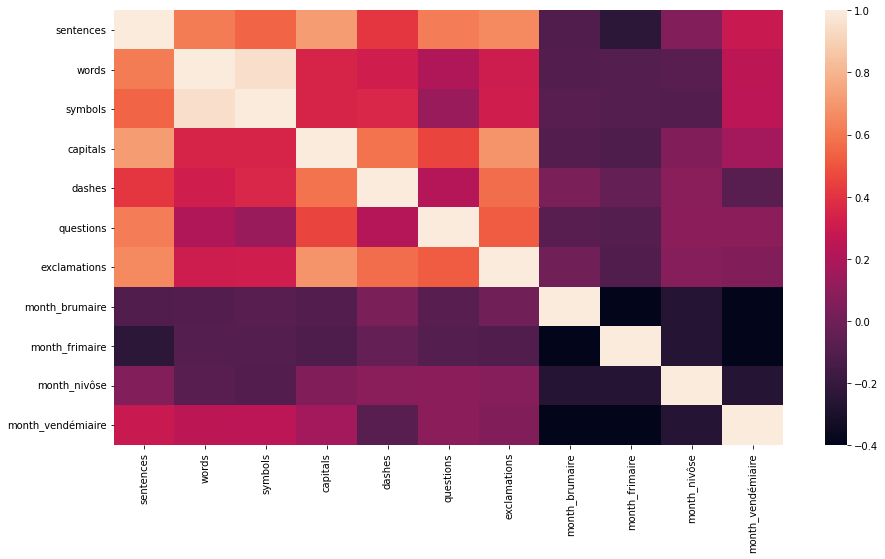

In [87]:
sns.heatmap(dum_df.corr())

In [33]:
target_column = "sentences"
dum_df = pd.get_dummies(data=df, columns=["month", "label"]).drop(columns=["name", "text"])
X, y = dum_df.drop(columns=[target_column]), dum_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

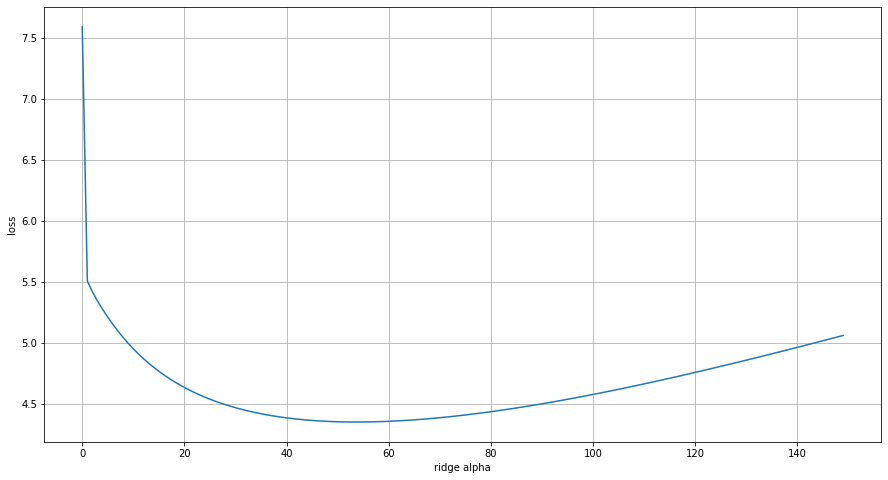

In [34]:
params = np.arange(0, 150, 1)
# params = np.arange(0, 1, 0.02)

loss = []
for p in params:
  model = Ridge(alpha=p).fit(X_train, y_train)
  y_pred = model.predict(X_test)
  loss.append(mean_squared_error(y_test, y_pred))
plt.plot(params, loss)
plt.grid()
plt.xlabel("ridge alpha")
plt.ylabel("loss")
plt.show()

alpha = params[np.argmin(loss)]

linreg MSE:  5.375
ridge MSE:  4.3523785484652375


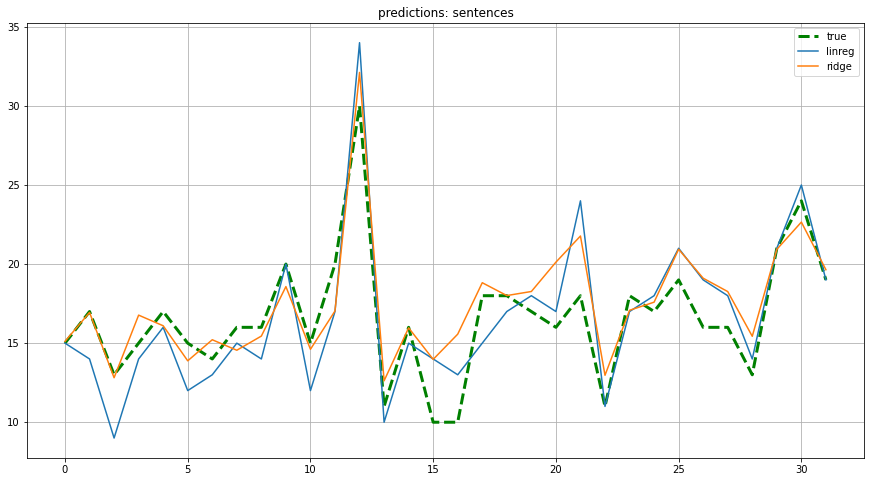

In [35]:
reg = LinearRegression().fit(X_train, y_train)
y_pred_reg = reg.predict(X_test).astype(int)
ridge = Ridge(alpha=alpha).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("linreg MSE: ", mean_squared_error(y_test, y_pred_reg))
print("ridge MSE: ", mean_squared_error(y_test, y_pred_ridge))

plt.rcParams["figure.figsize"] = (15, 8)
plt.plot(range(len(y_test)), y_test, label="true", color='g', linewidth=3, linestyle="dashed")
plt.plot(range(len(y_pred_reg)), y_pred_reg, label="linreg")
plt.plot(range(len(y_pred_ridge)), y_pred_ridge, label="ridge")
plt.title("predictions: " + target_column)
plt.grid()
plt.legend()
plt.show()

In [ ]:
ops = list(map(lambda x: x[:findexact(x, " ", 0)], df["text"]))
ops.sort(key=lambda x: x.lower())

In [ ]:
# todo: something that has to do with text processing ?

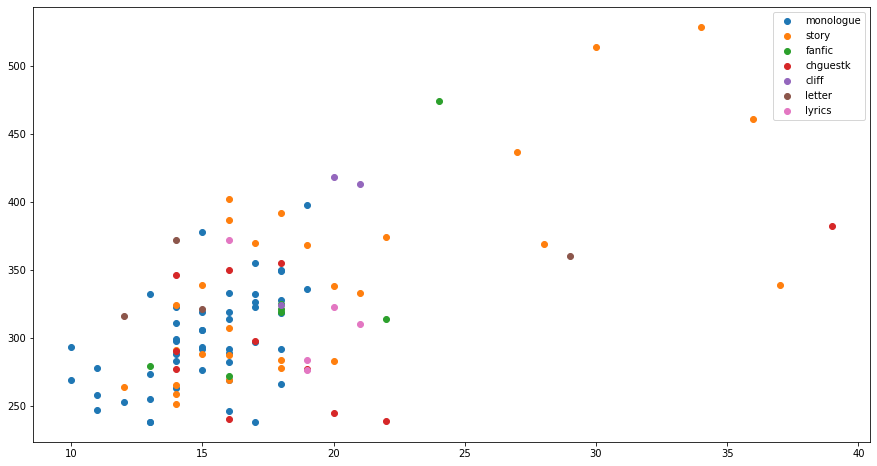

In [32]:
for label in labels:
  plt.scatter(df[df["label"] == label]["sentences"], df[df["label"] == label]["words"], label=label)
plt.legend()
plt.show()

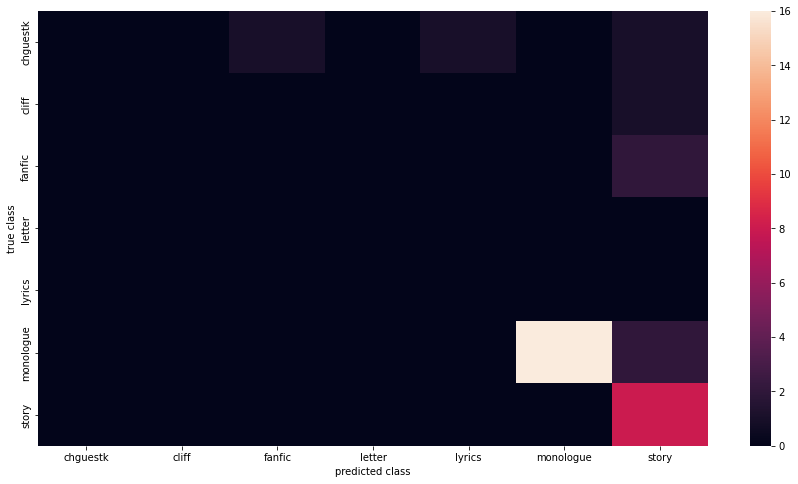

In [86]:
target_column = "label"
clf_dum_df = pd.get_dummies(data=df, columns=["month"]).drop(columns=["name", "text"])
X, y = clf_dum_df.drop(columns=[target_column]), clf_dum_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = RandomForestClassifier().fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

sns.heatmap(confusion_matrix(y_test, y_pred_clf, labels=clf.classes_),
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel("predicted class")
plt.ylabel("true class")
plt.show()